# <center> **Text Mining Project:**

___

Group Number: 12 
- Omar Jarir [m20201378@novaims.unl.pt]  
- Chung-Ting Huang [m20210437@novaims.unl.pt] 

___

**Installing the necessary Packages:**

Uncomment the following to install packages

In [1]:
#!pip install wordcloud
#!pip install pattern
#!pip install gensim
#!pip install keras
#!pip install tensorflow
#!pip install imblearn

**Imports:**

In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import gensim.downloader
import requests as rq
from io import BytesIO


from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ClassPredictionError
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
import warnings
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Masking, Activation
from keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Masking
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Masking
from tensorflow.keras import layers


In [3]:
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format

**Constants:**

In [4]:
random_state = 2022
train_w2v = False
load_w2v = False

**Helper Functions:**

In [5]:
def TopnGrams(corpus, top_k, n):
    '''
    Returns a dataframe of ngrams
    '''
    vec = CountVectorizer(ngram_range=(n, n), max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
        
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]
    return top_df

In [6]:
def PlotFrequencies(top_df):

    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# In bag of words, we observed 'U.S.', 'say', 'Say', 'says', 'year', 'new', 'New' appear frequently, so we added them to the list of stop words
# Alternatively we can use stop=gensim.parsing.preprocessing.STOPWORDS
stop = set(stopwords.words('english')).union(('U.S.', 'say', 'Say', 'says', 'year', 'new', 'New'))
# Alternatively we can use SnowballStemmer
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

In [9]:
def clean(text_list, lemmatize = True, stemming = False):
    '''
    Clean the corpus by
    1. Change all words to lower case
    2. Remove numbers, punctuation, tags, hashtags, links, abbreviations and white space
    3. Remove stop words
    4. Lemmatize
    5. Stemming
    '''
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        # TRANSFORM WORDS.
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)

        # REMOVING HASHTAGS.
        text = re.sub("@[A-Za-z0-9_]+"," ", text)
        text = re.sub("#[A-Za-z0-9_]+"," ", text)

        # REMOVING NUMBERS FROM TEXT
        text = " ".join([word for word in text.split() if not word.isdigit()])
                
        # REMOVE TAGS
        text = BeautifulSoup(text).get_text(separator=' ')
        
        #REMOVE STOP WORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        if lemmatize == True:
            text = " ".join([lemma.lemmatize(word, pos='n') for word in text.split()])
        
        if stemming == False:
            text = " ".join([stemmer.stem(word) for word in text.split()])     
            
         # REMOVING SINGLE CHARACTER WORDS.
        text = re.sub(r"\b[a-zA-Z]\b", " ", text)
      
        # REMOVING SINGLE CHARACTER WORDS.
        text = re.sub(r"\b[a-zA-Z]\b", " ", text)
        
        # Removing spaces
        text = " ".join(text.split())
        
        if len(text)== 0:
            text = " "
            
        updates.append(text)    
        
    return updates

# **1. Data importing:**


***

In [10]:
url_train = "https://raw.githubusercontent.com/omarja12/Text_Mining/main/train.csv"
url_test = "https://raw.githubusercontent.com/omarja12/Text_Mining/main/test.csv"
data_train = rq.get(url_train).content
data_test = rq.get(url_test).content
ds_train = pd.read_csv(BytesIO(data_train))
ds_test = pd.read_csv(BytesIO(data_test))

We drop the columns 'Id' from the training and testing datasets as they the bring no new informations.

In [11]:
ds_train.tail(2)

,Id,Closing Status,Headline1,Headline2,Headline3,Headline4,Headline5,Headline6,Headline7,Headline8,...,Headline16,Headline17,Headline18,Headline19,Headline20,Headline21,Headline22,Headline23,Headline24,Headline25
0,0,1,"Milan court convicts Berlusconi of tax evasion, gives 4-year sentence",Suicide bomber kills 20 in Afghan mosque,"After the biggest double dip since WW2, the UK is officially out of recession",Billions in Hidden Riches for Family of Chinese Leader,Former Italian Prime Minister Silvio Berlusconi sentenced to 4 years in jail in tax fraud trial.,"Through Her Sister's Eyes -- ""This seemingly magical ability -- to see through each other's eyes...",UN to investigate civilian deaths from US drone strikes. Special rapporteur on counter-terror op...,Ben Goldacre: Closed drug trials leave patients at risk and doctors in the dark: Drug companies ...,...,Britain rejects US request to use UK bases in nuclear standoff with Iran,New York Times blocked in China over Wen Jiabao wealth revelations. Unwelcome revelations about ...,What Are the Odds That Israel Just Attacked Sudan? - Armin Rosen - The Atlantic,"Opinion poll shows 43% of French people see Islam as a 'threat' to national identity, with two-t...",New York Times blocked by China after report on wealth of Wen Jiabao's family.,The British government opposed the establishment of the Nuremberg war crimes tribunals at the en...,"Ashok Khemka, a bureaucrat in India, has been transferred out of his job 43 times because of his...",Malala's parents overjoyed after first visit in UK hospital,"A victory for self-defence, but only a partial one: After 15 months in legal limbo, a Toronto ma...",British ExxonMobil oil chief 'assassinated' in Brussels street - Telegraph
1,1,0,"Iraq Police Training: $200 Million Wasted On Police Development Program, Auditors Say",Pussy Riot: will Vladimir Putin regret taking on Russia's cool women punks?,Syrian troops vow to 'purge' Aleppo of rebels as assault continues: Syrian troops fired tank sh...,Four Iranians Sentenced to Death Over $2.3 Bln Bank Fraud,"Christchurch, New Zealand rebuild plans unveiled today to take advantage of this unprecedented o...",Deadly Ebola Virus Reaches Ugandan Capital,Cat electrocuted; East Delhi goes powerless for 24 hours,"In Israel, at least 7 people have set themselves on fire over the last two weeks.",...,Britain just signed a 25 year contract to let a private company take care of their nuclear stock...,"Air pollution turns Beijing into ""Greyjing""",Israeli troops kill Palestinian at checkpoint,Couple stoned to death in Mali for having sex outside marriage,"Two Journalists Freed by Syrian Rebels After Weeklong Ordeal - ""Mr. Oerlemans said their captors...","Across Latin America, leaders appalled by the spread of drug-related violence are mulling polici...",Germany Breaks 25% Renewable Energy Barrier - It produced 67.9 billion kWh renewable energy in ...,Uruguay Considers Legalizing Marijuana to Stop Traffickers - NYTimes.com,"Beijing's Real Olympic Hero: Meet Ji Sizun, imprisoned for three years for daring to take China'...","Philippines birth control: Filipinos want it, priests don't -- In the Philippines, access to con..."
2,2,0,"Al Shabaab kidnaps, interrogates new Somali minister for women within hours of her appointment b...",The 'For Neville' email: two words that could bring down Murdoch,Explosion rocks Norwegian PM's office,"Speaker of The House says UK ""parliament has rediscovered its balls"" over Murdoch hacking affiair","James Murdoch knew of phone hacking, former News executives say\n",Shooting at Norwegian Social Democratic Youth (AUF) summer camp,"UN report claims North Korea and Iran are exchanging illicit missile technology, using China as ...",Greece defaults... selectively.,...,East Africa's famine: Millions of human beings are starving.,Egypt's military rulers ban foreign election observers: Egypt's ruling military council said for...,Large explosion in Oslo at Prime ministers office. Many p

In [12]:
ds_train.drop(columns=['Id'], inplace=True)
ds_test.drop(columns=['Id'], inplace=True)

# **2. Data Exploration:**

***

In [13]:
ds_train.head(2)

,Closing Status,Headline1,Headline2,Headline3,Headline4,Headline5,Headline6,Headline7,Headline8,Headline9,...,Headline16,Headline17,Headline18,Headline19,Headline20,Headline21,Headline22,Headline23,Headline24,Headline25
0,1,"Milan court convicts Berlusconi of tax evasion, gives 4-year sentence",Suicide bomber kills 20 in Afghan mosque,"After the biggest double dip since WW2, the UK is officially out of recession",Billions in Hidden Riches for Family of Chinese Leader,Former Italian Prime Minister Silvio Berlusconi sentenced to 4 years in jail in tax fraud trial.,"Through Her Sister's Eyes -- ""This seemingly magical ability -- to see through each other's eyes...",UN to investigate civilian deaths from US drone strikes. Special rapporteur on counter-terror op...,Ben Goldacre: Closed drug trials leave patients at risk and doctors in the dark: Drug companies ...,"The U.K. thinks a strike on Iran would be illegal, denies U.S. access to its bases",...,Britain rejects US request to use UK bases in nuclear standoff with Iran,New York Times blocked in China over Wen Jiabao wealth revelations. Unwelcome revelations about ...,What Are the Odds That Israel Just Attacked Sudan? - Armin Rosen - The Atlantic,"Opinion poll shows 43% of French people see Islam as a 'threat' to national identity, with two-t...",New York Times blocked by China after report on wealth of Wen Jiabao's family.,The British government opposed the establishment of the Nuremberg war crimes tribunals at the en...,"Ashok Khemka, a bureaucrat in India, has been transferred out of his job 43 times because of his...",Malala's parents overjoyed after first visit in UK hospital,"A victory for self-defence, but only a partial one: After 15 months in legal limbo, a Toronto ma...",British ExxonMobil oil chief 'assassinated' in Brussels street - Telegraph
1,0,"Iraq Police Training: $200 Million Wasted On Police Development Program, Auditors Say",Pussy Riot: will Vladimir Putin regret taking on Russia's cool women punks?,Syrian troops vow to 'purge' Aleppo of rebels as assault continues: Syrian troops fired tank sh...,Four Iranians Sentenced to Death Over $2.3 Bln Bank Fraud,"Christchurch, New Zealand rebuild plans unveiled today to take advantage of this unprecedented o...",Deadly Ebola Virus Reaches Ugandan Capital,Cat electrocuted; East Delhi goes powerless for 24 hours,"In Israel, at least 7 people have set themselves on fire over the last two weeks.",Pussy Riot: Our arrest signals start of repression campaign to spread fear. Members of punk band...,...,Britain just signed a 25 year contract to let a private company take care of their nuclear stock...,"Air pollution turns Beijing into ""Greyjing""",Israeli troops kill Palestinian at checkpoint,Couple stoned to death in Mali for having sex outside marriage,"Two Journalists Freed by Syrian Rebels After Weeklong Ordeal - ""Mr. Oerlemans said their captors...","Across Latin America, leaders appalled by the spread of drug-related violence are mulling polici...",Germany Breaks 25% Renewable Energy Barrier - It produced 67.9 billion kWh renewable energy in ...,Uruguay Considers Legalizing Marijuana to Stop Traffickers - NYTimes.com,"Beijing's Real Olympic Hero: Meet Ji Sizun, imprisoned for three years for daring to take China'...","Philippines birth control: Filipinos want it, priests don't -- In the Philippines, access to con..."


**Looking for Missing Values:**

We can see that the columns 'Headline3', 'Headline11' and 'Headline23' contain missing values, we will fill the missing values using the following string " ".

In [14]:
ds_train.isna().sum()

Closing Status    0
Headline1         0
Headline2         0
Headline3         3
Headline4         0
Headline5         0
Headline6         0
Headline7         0
Headline8         0
Headline9         0
Headline10        0
Headline11        3
Headline12        0
Headline13        0
Headline14        0
Headline15        0
Headline16        0
Headline17        0
Headline18        0
Headline19        0
Headline20        0
Headline21        0
Headline22        0
Headline23        1
Headline24        0
Headline25        0
dtype: int64

In [15]:
ds_train[['Headline3', 'Headline11', 'Headline23']] = \
          ds_train[['Headline3', 'Headline11', 'Headline23']]. fillna(" ")

**Creating a list containing the headlines columns.**

In [16]:
Headlines = list(ds_train.columns[1:])

**Convert the headlines column from object type to the string type.**

In [17]:
ds_train[Headlines] = ds_train[Headlines].astype('str') 

In [18]:
# check the shape of the training dataset.
print("The shape of the train dataset.", ds_train.shape)
print("The shape of the test dataset.", ds_test.shape)

The shape of the train dataset. (1690, 26)
The shape of the test dataset. (299, 25)


** The target variable:**

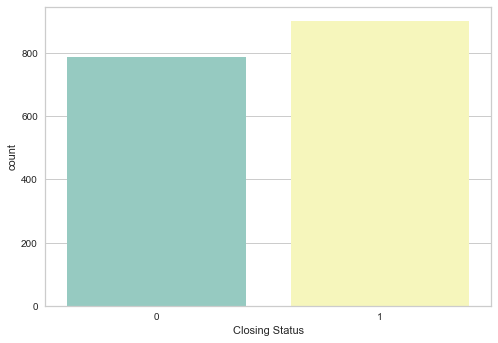

In [19]:
sns.countplot(data=ds_train, x='Closing Status', palette="Set3")
plt.show()

In [20]:
ds_train['Closing Status'].value_counts()

1    902
0    788
Name: Closing Status, dtype: int64

From the plot above we can see that the classes in the target variable are kind of balanced.

**Checking for Missing Value:**

Our target variable does not contains any missing values.

In [21]:
ds_train['Closing Status'].isna().sum() 

0

**Words count:**

We create an empty dataframe that will contains the words count of the headers.

In [22]:
ds_train_words = pd.DataFrame()

Fetch wordcount for each headline.

In [23]:
for idx, col in enumerate(Headlines):
    ds_train_words[f'Wordcount{idx+1}']  = ds_train[col].apply(lambda x: len(str(x).split(" ")))

Describing the new dataframe:

In [24]:
ds_train_words.describe().T

,count,mean,std,min,25%,50%,75%,max
Wordcount1,1690.00,16.83,11.18,2.00,9.00,12.00,23.00,56.00
Wordcount2,1690.00,16.86,11.00,3.00,9.00,12.00,23.00,55.00
Wordcount3,1690.00,16.50,11.04,2.00,9.00,12.00,22.00,58.00
Wordcount4,1690.00,17.40,11.60,3.00,9.00,12.00,24.00,59.00
Wordcount5,1690.00,17.59,11.50,3.00,9.00,13.00,24.00,56.00
Wordcount6,1690.00,18.19,11.58,3.00,9.00,14.00,25.00,56.00
Wordcount7,1690.00,17.01,11.55,3.00,9.00,12.00,23.00,59.00
Wordcount8,1690.00,16.69,10.81,3.00,9.00,13.00,22.00,56.00
Wordcount9,1690.00,18.96,11.57,3.00,10.00,15.00,26.00,54.00
Wordcount10,1690.00,17.67,11.33,3.00,9.00,13.00,24.00,57.00


The distribution of the words count.

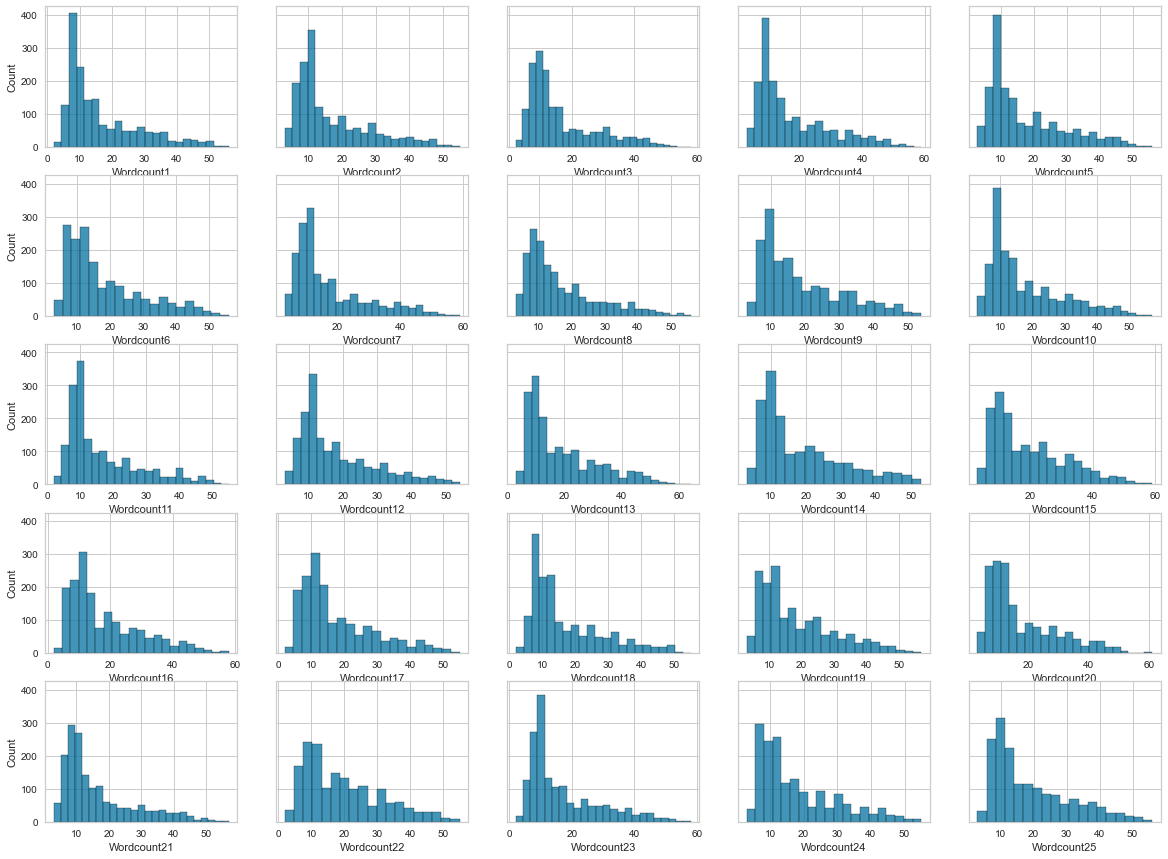

In [25]:
fig, ax = plt.subplots(5, 5, sharey=True, figsize=(20, 15))
for var, subplot in zip(ds_train_words[ds_train_words.columns], ax.flatten()):
    sns.histplot(data=ds_train_words, x=var, ax=subplot)
plt.show()

Creating a new column that contains the sum of words count over the rows.

In [26]:
ds_train_words['WordcountTotal'] = ds_train_words[ds_train_words.columns].sum(axis=1)

Histogram of the total world counts. It seems to be normally distributed.

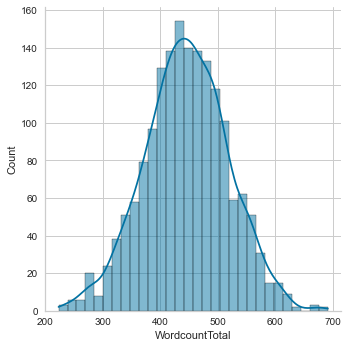

In [27]:
sns.displot(data=ds_train_words, x='WordcountTotal', kde=True)
plt.show()

In [28]:
print("The mean value of the WordcountTotal variable is equal to:", ds_train_words['WordcountTotal'].mean())
print("The standard deviation of the WordcountTotal variable is equal to:", ds_train_words['WordcountTotal'].std())

The mean value of the WordcountTotal variable is equal to: 445.33786982248523
The standard deviation of the WordcountTotal variable is equal to: 72.4385453442264


**Descriptive Statistics of the words in the corpus:**

Creating a list containing all the words in the dataframe.

In [29]:
all_words=[]

for col in Headlines:
    all_words+=' '.join(ds_train[col]).split()

In [30]:
freq = pd.Series(all_words).value_counts()

Finding the top 10 words.

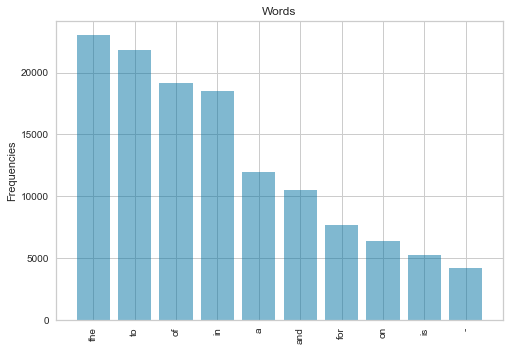

In [31]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

As we can see the most commum words are stopwords, 
we will be deleting them in the Data Preprocessing phase.


In [32]:
ds_train['HeadlinesTotal'] = \
                 ds_train[Headlines].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

Positive words


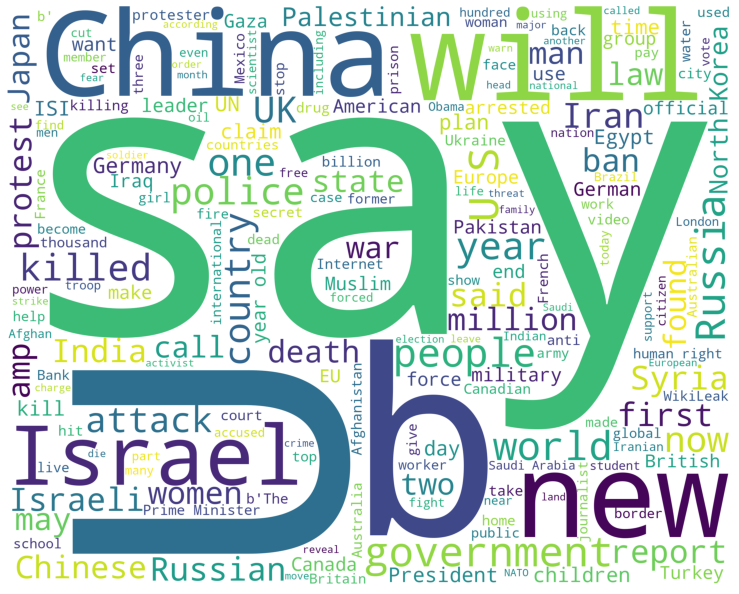

Negative words


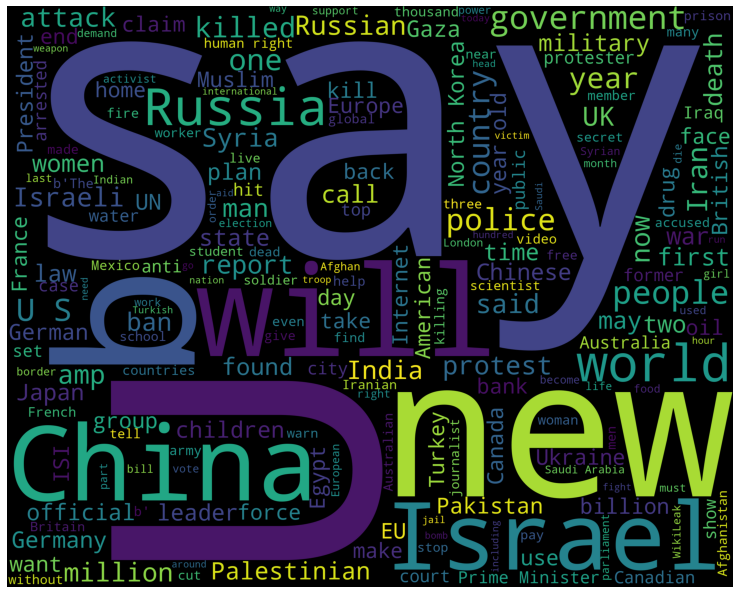

In [33]:
train_pos = ds_train[ds_train['Closing Status'] == 1]
train_pos = train_pos['HeadlinesTotal']
train_neg = ds_train[ds_train['Closing Status'] == 0]
train_neg = train_neg['HeadlinesTotal']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

# **3. Data Preprocessing:**

***

**Cleaning the training dataset:**

Creating a clean dataframe with the same columns as the training dataset, expect for the dependent variable.


In [34]:
ds_train_clean = pd.DataFrame(columns=Headlines)

for col in Headlines:
    clean_columns = clean(ds_train[col], lemmatize = True, stemming = False) 
    ds_train_clean[col] = clean_columns

100%|██████████| 1690/1690 [00:02<00:00, 782.13it/s]


**Cleaning the testing dataset:**

Creating a clean dataframe with the same columns as the test dataset.

In [35]:
ds_test_clean = pd.DataFrame(columns=ds_test.columns)

for col in Headlines:
    clean_columns = clean(ds_test[col], lemmatize = True, stemming = False) 
    ds_test_clean[col] = clean_columns

100%|██████████| 299/299 [00:00<00:00, 806.39it/s]


___

# **4. Feature Engineering:**

***

We concatanate all the columns into one, in order to create features later.

In [36]:
ds_train_clean['HeadlinesTotal'] = \
                 ds_train_clean[Headlines].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [37]:
ds_test_clean['HeadlinesTotal'] = \
              ds_test_clean[Headlines].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

## **Exploring the most common n-grams:**

***

#### **n-gram (1,1):**

***

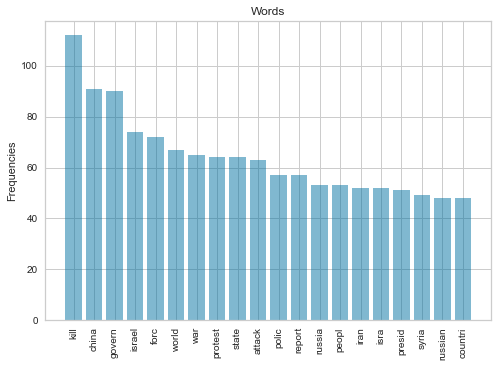

In [38]:
PlotFrequencies(TopnGrams(ds_train_clean['Headline21'], top_k=20, n=1))

#### **n-gram (2,2):**

***

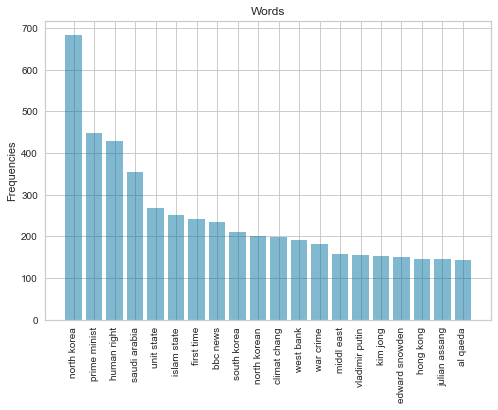

In [39]:
PlotFrequencies(TopnGrams(ds_train_clean['HeadlinesTotal'], top_k=20, n=2))

#### **n-gram (3,3):**

***

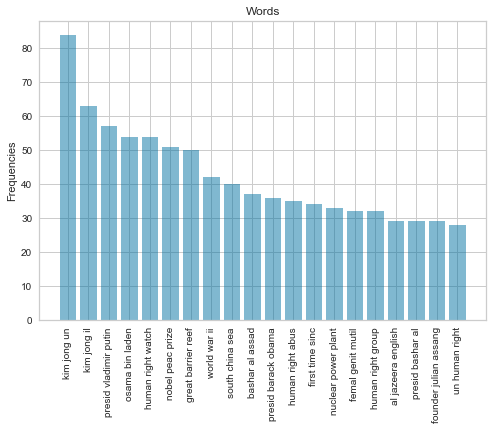

In [40]:
PlotFrequencies(TopnGrams(ds_train_clean['HeadlinesTotal'], top_k=20, n=3))

#### **n-gram (4,4):**

***

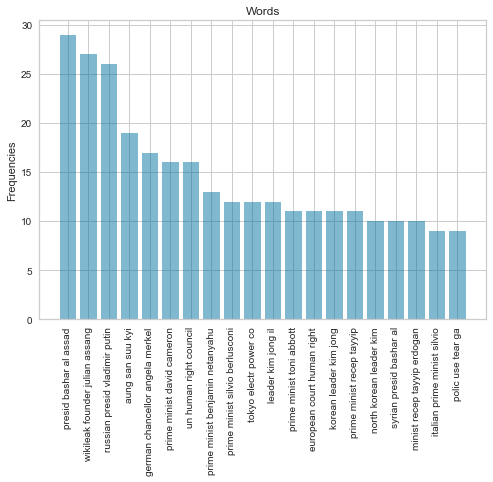

In [41]:
PlotFrequencies(TopnGrams(ds_train_clean['HeadlinesTotal'], top_k=20, n=4))

#### n-gram (5,5):

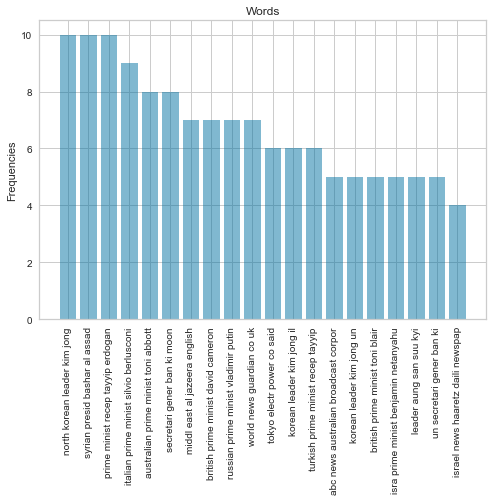

In [42]:
PlotFrequencies(TopnGrams(ds_train_clean['HeadlinesTotal'], top_k=20, n=5))

### **Words Cloud**

***

In [43]:
ds_train_clean.head(1)

,Headline1,Headline2,Headline3,Headline4,Headline5,Headline6,Headline7,Headline8,Headline9,Headline10,...,Headline17,Headline18,Headline19,Headline20,Headline21,Headline22,Headline23,Headline24,Headline25,HeadlinesTotal
0,milan court convict berlusconi tax evas give sentenc,suicid bomber kill afghan mosqu,biggest doubl dip sinc ww uk offici recess,billion hidden rich famili chines leader,former italian prime minist silvio berlusconi sentenc year jail tax fraud trial,sister eye seemingli magic abil see eye feel experi perhap even share thought stun neurologist m...,un investig civilian death drone strike special rapporteur counter terror oper condemn barack ob...,ben goldacr close drug trial leav patient risk doctor dark drug compani hide inform drug doctor ...,think strike iran would illeg deni access base,presid vladimir putin flatli reject thursday western critic imprison pussi riot punk protest ban...,...,york time block china wen jiabao wealth revel unwelcom revel wealth famili chines premier known ...,odd israel attack sudan armin rosen atlant,opinion poll show french peopl see islam threat nation ident two third say muslim poorli integr ...,york time block china report wealth wen jiabao famili,british govern oppos establish nuremberg war crime tribun end wwll want select nazi leader summa...,ashok khemka bureaucrat india transfer job time determin follow rule whistleblow senior career b...,malala parent overjoy first visit uk hospit,victori self defenc partial one month legal limbo toronto man defend love one free man mose mahi...,british exxonmobil oil chief assassin brussel street telegraph,milan court convict berlusconi tax evas give sentenc suicid bomber kill afghan mosqu biggest dou...


Positive words


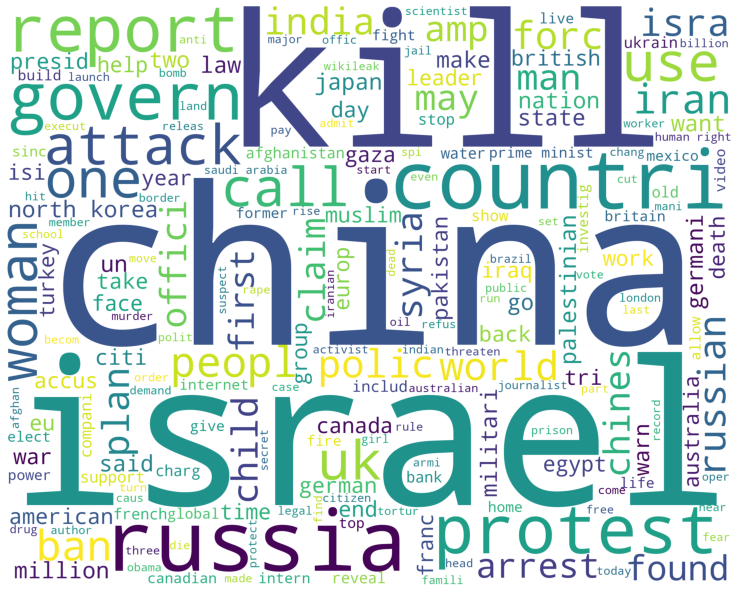

Negative words


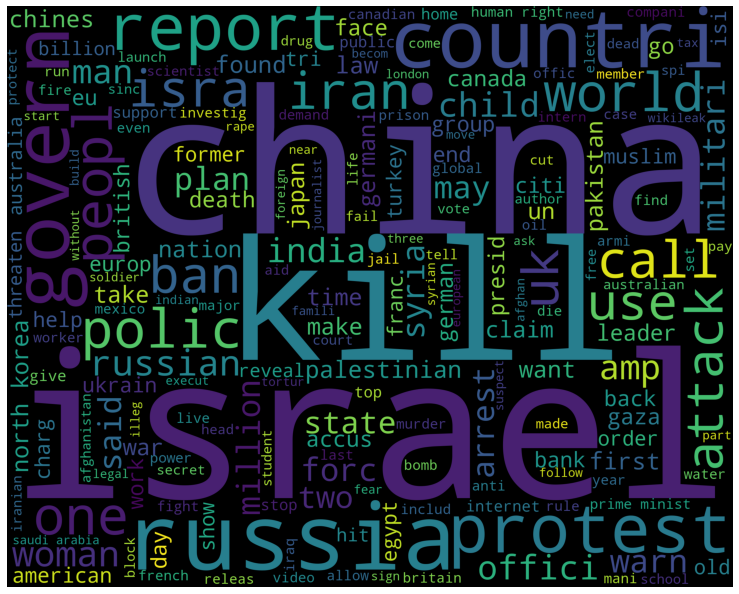

In [44]:
train_pos = ds_train_clean[ds_train['Closing Status'] == 1]
train_pos = train_pos['HeadlinesTotal']
train_neg = ds_train_clean[ds_train['Closing Status'] == 0]
train_neg = train_neg['HeadlinesTotal']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

**Removing Top words common in Positive and Negative dataset:**

These words are like stop words, they don't provide mutual information.

In [45]:
def top_common_words(train_pos, train_neg):
    pos_ngrams = TopnGrams(train_pos, n=1, top_k=100)
    neg_ngrams = TopnGrams(train_neg, n=1, top_k=100)
    return pd.merge(pos_ngrams, neg_ngrams, on='Ngram')

top_words = top_common_words(train_pos=train_pos, train_neg=train_neg)
top_words

,Ngram,Freq_x,Freq_y
0,kill,1234,1027
1,world,1108,972
2,china,1059,868
3,israel,1032,862
4,govern,1028,881
...,...,...,...
90,intern,343,290
91,isi,334,285
92,bomb,324,298
93,dead,324,279


In [46]:
def remove_common_words(text_list, top_words=top_words):
    '''
    Remove top words that appear in positive and negative corpus
    '''
    updates = []
    for j in tqdm(text_list):
        text = j
        
        #REMOVE COMMON WORDS.
        text = " ".join([word for word in text.split() if word not in top_words['Ngram'].to_list()])
        
        updates.append(text)    
        
    return updates


clean_columns = remove_common_words(ds_train_clean['HeadlinesTotal'])
ds_train_clean['HeadlinesTotal'] = clean_columns

100%|██████████| 1690/1690 [00:04<00:00, 401.75it/s]


Positive words


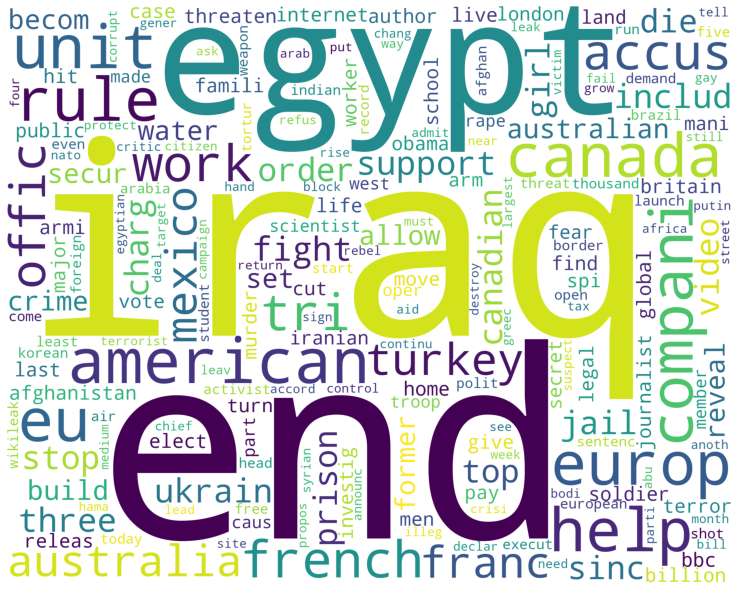

Negative words


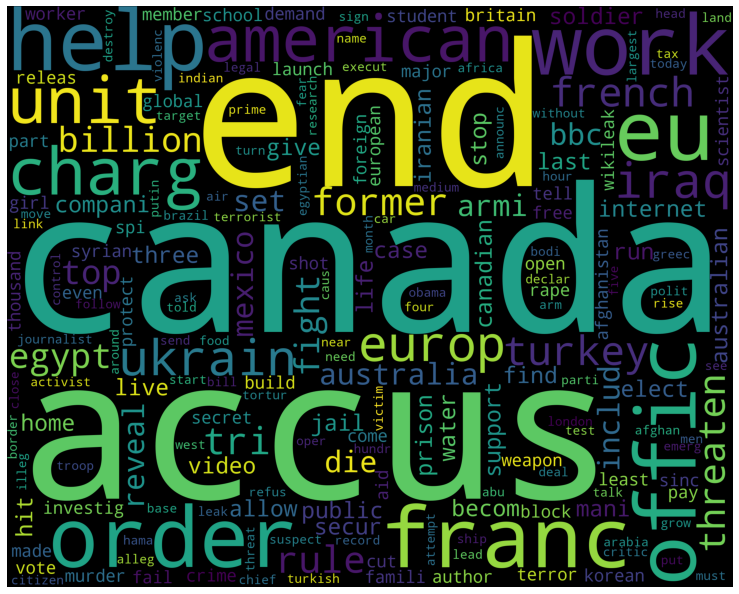

In [47]:
train_pos = ds_train_clean[ds_train['Closing Status'] == 1]
train_pos = train_pos['HeadlinesTotal']
train_neg = ds_train_clean[ds_train['Closing Status'] == 0]
train_neg = train_neg['HeadlinesTotal']
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

___

## **Corpus Split:**

***

We define the target variable,and use stratify sampling to make sure train and validation have the same distribution of closing status.

In [48]:
y = np.array(ds_train['Closing Status'])

In [49]:
X_train, X_validation, y_train, y_validation = train_test_split(
    ds_train_clean, y, test_size=0.2, stratify=y, random_state=random_state)

In [50]:
#X_train, X_validation, y_train, y_validation = train_test_split(
#    ds_train_clean, ds_train['Closing Status'], test_size=0.2, stratify=ds_train['Closing Status'],
#     random_state=random_state)

## **Creating CountVectorizer Features:**

***

In [51]:
# Vectorization parameters:

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# The type of counts.
BINARY=False

# Limit on the number of features. We use the top 300 features.
TOP_K = 300 # 150

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 10
MAX_FEATURES=30000

def ngram_vectorize_bow(train_texts, train_labels, val_texts, test_texts):
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'float64',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'max_features': MAX_FEATURES,
            'binary': BINARY,
            #'analyzer': clean, 
    }
    vectorizer = CountVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Vectorize the test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float64')
    x_val = selector.transform(x_val).astype('float64')
    x_test = selector.transform(x_test).astype('float64')
    return x_train.toarray(), x_val.toarray(), x_test.toarray()

def ngram_vectorize_bows(x_train, y_train, x_vald, x_test):
    bow_train = np.zeros((len(Headlines), len(x_train), TOP_K))
    bow_vald = np.zeros((len(Headlines), len(x_vald), TOP_K))
    bow_test = np.zeros((len(Headlines), len(x_test), TOP_K))
    for (i, col) in enumerate(Headlines):
        bow_train[i], bow_vald[i], bow_test[i] = ngram_vectorize_bow(x_train[col], y_train, x_vald[col], x_test[col])
    return bow_train, bow_vald, bow_test

returning the X_bow used to train the models, and the X_bow_validation used to validate the model performances. 

In [52]:
X_bow_vec, X_bow_validation_vec, X_bow_test_vec = ngram_vectorize_bows(X_train, y_train, X_validation, ds_test_clean)

In [53]:
X_bow, X_bow_validation, X_bow_test = ngram_vectorize_bow(X_train["HeadlinesTotal"], y_train, 
                                            X_validation["HeadlinesTotal"], 
                                            ds_test_clean["HeadlinesTotal"])

## **Creating TF-IDF Features:**

***

In [54]:
# Vectorization parameters:

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 300

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum and Maximum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 10
MAX_DOCUMENT_FREQUENCY = 0.8
MAX_FEATURES=30000

def tfidf(train_texts, train_labels, val_texts, test_texts):
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'max_df': MAX_DOCUMENT_FREQUENCY,  
            'max_features': MAX_FEATURES,
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Vectorize test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float64')
    x_val = selector.transform(x_val).astype('float64')
    x_test = selector.transform(x_test).astype('float64')
    return x_train.toarray(), x_val.toarray(), x_test.toarray()

def tfidf_vector(x_train, y_train, x_vald, x_test):
    tfidf_train = np.zeros((len(Headlines), len(x_train), TOP_K))
    tfidf_vald = np.zeros((len(Headlines), len(x_vald), TOP_K))
    tfidf_test = np.zeros((len(Headlines), len(x_test), TOP_K))
    for (i, col) in enumerate(Headlines):
        tfidf_train[i], tfidf_vald[i], tfidf_test[i] = tfidf(x_train[col], y_train, x_vald[col], x_test[col])
    return tfidf_train, tfidf_vald, tfidf_test

returning the X_tfidf used to train the models, and the X_tfidf_validation used to validate the model performances. 

In [55]:
X_tfidf_vec, X_tfidf_validation_vec, X_tfidf_test_vec = tfidf_vector(X_train, y_train, X_validation, ds_test_clean)

In [56]:
X_tfidf, X_tfidf_validation, X_tfidf_test = tfidf(X_train["HeadlinesTotal"], y_train, 
                                            X_validation["HeadlinesTotal"],
                                            ds_test_clean["HeadlinesTotal"])

## **Creating HashingVectorizer Features:**

***

In [57]:
# Vectorization parameters:

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# The type of counts.
BINARY=False

# Limit on the number of features. We use the top 20K features.
TOP_K = 300

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'
MAX_FEATURES= 30000#400

def ngram_vectorize_hash(train_texts, train_labels, val_texts, test_texts):
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'binary': BINARY,
    }
    vectorizer = HashingVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Vectorize test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float64')
    x_val = selector.transform(x_val).astype('float64')
    x_test = selector.transform(x_test).astype('float64')
    return x_train.toarray(), x_val.toarray(), x_test.toarray()

returning the X_hash used to train the models, and the X_hash_validation used to validate the model performances. 

In [58]:
X_hash, X_hash_validation, X_hash_test = ngram_vectorize_hash(X_train["HeadlinesTotal"], y_train, 
                                            X_validation["HeadlinesTotal"],
                                            ds_test_clean["HeadlinesTotal"])

**Creating the Words Embedding Features:**

In [59]:
if train_w2v:
    w2v = gensim.downloader.load('glove-twitter-25')

In [60]:
def corpus_to_vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            # Skip words not in the model
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.word_vec(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

def average_w2v(corpus):
    '''
    Generate 1 vector for each document by summing the vectors and take the average of each dimension
    '''
    doc_vec = []
    for document in corpus:
        sentence_vector = 0
        count = 0
        for word in document.split():
            if word in w2v.index_to_key:
                count+=1
                sentence_vector = np.add(sentence_vector, w2v.get_vector(word))
        avg_vector=sentence_vector/count
        #doc_vec.append(sentence_vector)
        doc_vec.append(avg_vector)
    return np.array(doc_vec)

*Warning: this takes a long time*

In [61]:
if train_w2v:
    #X_vec = corpus_to_vec(X_train['HeadlinesTotal'])
    #np.save('X_vec_train.npy', X_vec)
    X_vec_per_headline = []
    for headline in tqdm(Headlines):
        X_vec_per_headline.append(corpus_to_vec(X_train[headline]))
    np.save('X_vec_per_headline.npy', X_vec_per_headline)
elif load_w2v:
    X_vec_per_headline = np.load('X_vec_per_headline.npy', allow_pickle=True)
    X_vec_per_headline = X_vec_per_headline.tolist()

100%|██████████| 25/25 [35:52<00:00, 86.10s/it]


In [62]:
%%time
if train_w2v:
    X_vec = average_w2v(X_train['HeadlinesTotal'])
    np.save('X_vec.npy', X_vec)    
elif load_w2v:
    X_vec = np.load('X_vec.npy')

Wall time: 28min 46s


In [63]:
if train_w2v:
    X_vec_validation = average_w2v(X_validation['HeadlinesTotal'])
    np.save('X_vec_validation.npy', X_vec_validation)
elif load_w2v:
    X_vec_validation = np.load('X_vec_validation.npy')

# **5. Training and selecting the classifiers:**

***

**Model Class**

In [64]:
class TextClassifier:
    def __init__(self, model):
        self.model = model
        
    def k_fold(self, x_train, y_train, nsplits=3, nrepeats=20, scoring=['recall', 'precision', 'accuracy', 'f1_weighted', 'roc_auc']):
        '''
        Evaluating a classification model using repeated k-fold cross-validation
        Possible scoring: ['accuracy', 'f1_weighted', 'roc_auc', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted']
        '''
        # prepare the cross-validation procedure
        cv = RepeatedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=random_state)
        
        scores = cross_validate(self.model, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

        # report performance:
        for s in scoring:
            print('%s: mean: %.3f, std: %.3f' % (s, np.mean(scores[f'test_{s}']), np.std(scores[f'test_{s}'])))

        return scores

    def fit_then_predict(self, x_train, y_train, x_vald, y_vald, return_prob=False, **kwargs):
        self.model.fit(x_train, y_train)

        # Predicting the target for x_vald.
        pred_train = pd.DataFrame()
        pred_vald = pd.DataFrame()
        pred_train['Actual'] = y_train
        pred_train['Prediction'] = self.model.predict(x_train) 
        pred_vald['Actual'] = y_vald
        pred_vald['Prediction'] = self.model.predict(x_vald) 

        if return_prob:
            # Probabilities of belong to the class 0 and 1.
            pred_proba = self.model.predict_proba(x_train)
            pred_train['Class 0 prob.'] = pred_proba[:, 0]
            pred_train['Class 1 prob.'] = pred_proba[:, 1]

            pred_proba = self.model.predict_proba(x_vald)
            pred_vald['Class 0 prob.'] = pred_proba[:, 0]
            pred_vald['Class 1 prob.'] = pred_proba[:, 1]
        
        self.pred_train = pred_train
        self.pred_vald = pred_vald

        return pred_vald 

    def fit_then_predict_vec(self, x_train_vec, y_train, x_vald_vec, y_vald, return_prob=False, pos_threshold=0.5, **kwargs):
        '''
        Fit and predict each headline. Each row in the original dataset has 25 headlines.
        In this method each headline is a datapoint. A prediction for a row is the majority vote
        of the prediction for each headline in the row. 
        '''
        x_train_shape = x_train_vec.shape
        x_train_flatten = x_train_vec.reshape((x_train_shape[0] * x_train_shape[1], x_train_shape[2]))
        y_train_repeated = np.repeat(y_train, x_train_shape[0]) 

        x_vald_shape = x_vald_vec.shape
        x_vald_flatten = x_vald_vec.reshape((x_vald_shape[0] * x_vald_shape[1], x_vald_shape[2]))       

        self.model.fit(x_train_flatten, y_train_repeated, **kwargs)

        # Predicting the target for x_vald.
        pred_train = pd.DataFrame()
        pred_vald = pd.DataFrame()
        pred_train['Actual'] = y_train
        pred_vald['Actual'] = y_vald

        if return_prob:
            y_pred_train = self.model.predict_proba(x_train_flatten)[:, 1].reshape((x_train_shape[0], x_train_shape[1]))
            y_pred_vald = self.model.predict_proba(x_vald_flatten)[:, 1].reshape((x_vald_shape[0], x_vald_shape[1]))
            for i, headline in enumerate(Headlines):
                pred_train[headline] = y_pred_train[i]
                pred_vald[headline] = y_pred_vald[i]
            print((pred_train[Headlines].mean(axis=1) > pos_threshold).astype(int))
            pred_train['Prediction'] = (pred_train[Headlines].mean(axis=1) > pos_threshold).astype(int)
            pred_vald['Prediction'] = (pred_vald[Headlines].mean(axis=1) > pos_threshold).astype(int)
        else:
            y_pred_train = self.model.predict(x_train_flatten).reshape((x_train_shape[0], x_train_shape[1]))
            y_pred_vald = self.model.predict(x_vald_flatten).reshape((x_vald_shape[0], x_vald_shape[1]))
            for i, headline in enumerate(Headlines):
                pred_train[headline] = y_pred_train[i]
                pred_vald[headline] = y_pred_vald[i]
            pred_train['Prediction'] = pred_train[Headlines].mode(axis=1)[0]
            pred_vald['Prediction'] = pred_vald[Headlines].mode(axis=1)[0]
            
        self.pred_train = pred_train
        self.pred_vald = pred_vald

        return self.pred_vald

    def classification_report(self, x_train, y_train, x_vald, y_vald):
        visualizer = ClassificationReport(self.model, support=True)

        visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
        visualizer.score(x_vald, y_vald)        # Evaluate the model on the test data
        visualizer.show()                       # Finalize and show the figure

    def performance_metrics(self):
        '''
        Function to create dataframe with metrics
        '''
        measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
        train_results = [metrics.accuracy_score(self.pred_train['Actual'], self.pred_train['Prediction']),
                    metrics.precision_score(self.pred_train['Actual'], self.pred_train['Prediction']),
                    metrics.recall_score(self.pred_train['Actual'], self.pred_train['Prediction'], average='weighted'),
                    metrics.f1_score(self.pred_train['Actual'], self.pred_train['Prediction'], average='weighted'),
                    metrics.roc_auc_score(self.pred_train['Actual'], self.pred_train['Prediction'])    
                    ]
        test_results = [metrics.accuracy_score(self.pred_vald['Actual'], self.pred_vald['Prediction']),
                    metrics.precision_score(self.pred_vald['Actual'], self.pred_vald['Prediction']),
                    metrics.recall_score(self.pred_vald['Actual'], self.pred_vald['Prediction'], average='weighted'),
                    metrics.f1_score(self.pred_vald['Actual'], self.pred_vald['Prediction'], average='weighted'),
                    metrics.roc_auc_score(self.pred_vald['Actual'], self.pred_vald['Prediction']),   
                ]
        if 'Class 1 prob.' in self.pred_train:
            measures_list.append('AUC_Proba')
            train_results.append(metrics.roc_auc_score(self.pred_train['Actual'], self.pred_train['Class 1 prob.']))
            test_results.append(metrics.roc_auc_score(self.pred_vald['Actual'], self.pred_vald['Class 1 prob.']))

        return pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})


## **K Nearest Neighbors:** 

___

In [124]:
knn = TextClassifier(KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance'))

### **Bow:**

In [125]:
# Evaluating a K Nearest Neighbors classification model using repeated k-fold cross-validation.
knn.k_fold(X_bow, y_train, nsplits=3, nrepeats=20);
knn.fit_then_predict(X_bow, y_train, X_bow_validation, y_validation, return_prob=True)
knn.performance_metrics()

recall: mean: 0.681, std: 0.031
precision: mean: 0.644, std: 0.031
accuracy: mean: 0.628, std: 0.022
f1_weighted: mean: 0.627, std: 0.022
roc_auc: mean: 0.678, std: 0.022


,Measure,Train,Test
0,ACCURACY,1.00,0.52
1,PRECISION,1.00,0.55
2,RECALL,1.00,0.52
3,F1 SCORE,1.00,0.52
4,AUC,1.00,0.52
5,AUC_Proba,1.00,0.49


### **Bow Vector:**

In [126]:
knn.fit_then_predict_vec(X_bow_vec, y_train, X_bow_validation_vec, y_validation, return_prob=True)
knn.performance_metrics()

0       0
1       1
2       0
3       0
4       1
       ..
1347    1
1348    1
1349    1
1350    0
1351    1
Length: 1352, dtype: int32


,Measure,Train,Test
0,ACCURACY,0.52,0.52
1,PRECISION,0.54,0.53
2,RECALL,0.52,0.52
3,F1 SCORE,0.50,0.43
4,AUC,0.50,0.49


### **Tf-idf:**

In [127]:
# Evaluating a K Nearest Neighbors classification model using repeated k-fold cross-validation.
knn.k_fold(X_tfidf, y_train, nsplits=3, nrepeats=20);
knn.fit_then_predict(X_tfidf, y_train, X_tfidf_validation, y_validation, return_prob=True)
knn.performance_metrics()

recall: mean: 0.768, std: 0.028
precision: mean: 0.713, std: 0.028
accuracy: mean: 0.710, std: 0.018
f1_weighted: mean: 0.709, std: 0.019
roc_auc: mean: 0.773, std: 0.018


,Measure,Train,Test
0,ACCURACY,1.00,0.49
1,PRECISION,1.00,0.52
2,RECALL,1.00,0.49
3,F1 SCORE,1.00,0.48
4,AUC,1.00,0.48
5,AUC_Proba,1.00,0.47


### **Tf-idf Vector:**

In [128]:
knn.fit_then_predict_vec(X_tfidf_vec, y_train, X_tfidf_validation_vec, y_validation, return_prob=True)
knn.performance_metrics()

0       0
1       1
2       0
3       0
4       1
       ..
1347    1
1348    1
1349    1
1350    1
1351    1
Length: 1352, dtype: int32


,Measure,Train,Test
0,ACCURACY,0.52,0.49
1,PRECISION,0.54,0.51
2,RECALL,0.52,0.49
3,F1 SCORE,0.50,0.38
4,AUC,0.51,0.46


,Measure,Train,Test
0,ACCURACY,0.52,0.49
1,PRECISION,0.54,0.51
2,RECALL,0.52,0.49
3,F1 SCORE,0.50,0.38
4,AUC,0.51,0.46


### **Hash:**

In [129]:
# Evaluating a K Nearest Neighbors classification model using repeated k-fold cross-validation.
knn.k_fold(X_hash, y_train, nsplits=3, nrepeats=20);
knn.fit_then_predict(X_hash, y_train, X_hash_validation, y_validation, return_prob=True)
knn.performance_metrics()

recall: mean: 0.708, std: 0.032
precision: mean: 0.647, std: 0.027
accuracy: mean: 0.637, std: 0.019
f1_weighted: mean: 0.635, std: 0.019
roc_auc: mean: 0.689, std: 0.022


,Measure,Train,Test
0,ACCURACY,1.00,0.49
1,PRECISION,1.00,0.51
2,RECALL,1.00,0.49
3,F1 SCORE,1.00,0.48
4,AUC,1.00,0.48
5,AUC_Proba,1.00,0.46


### **Words Embedding:**

In [130]:
# Insert comment here.
#knn.k_fold(X_vec, y_train, nsplits=3, nrepeats=20);
#knn.fit_then_predict(X_vec, y_train, X_vec_validation, y_validation, return_prob=True)
#knn.performance_metrics()

recall: mean: 0.620, std: 0.045
precision: mean: 0.541, std: 0.024
accuracy: mean: 0.515, std: 0.018
f1_weighted: mean: 0.508, std: 0.020
roc_auc: mean: 0.515, std: 0.023


,Measure,Train,Test
0,ACCURACY,1.00,0.50
1,PRECISION,1.00,0.52
2,RECALL,1.00,0.50
3,F1 SCORE,1.00,0.49
4,AUC,1.00,0.49
5,AUC_Proba,1.00,0.48


## **LogisticRegression:**

___

In [131]:
log_reg = TextClassifier(LogisticRegressionCV(solver = 'liblinear', cv=5, max_iter=500, penalty='l1',
                                              random_state=random_state))
# LogisticRegressionCV uses k-fold validation to find the best hyperparameter.

### **Bow:**

In [132]:
log_reg.k_fold(X_bow, y_train, nsplits=3, nrepeats=20);
log_reg.fit_then_predict(X_bow, y_train, X_bow_validation, y_validation, return_prob=True)

recall: mean: 0.750, std: 0.028
precision: mean: 0.744, std: 0.024
accuracy: mean: 0.729, std: 0.020
f1_weighted: mean: 0.728, std: 0.020
roc_auc: mean: 0.809, std: 0.019


,Actual,Prediction,Class 0 prob.,Class 1 prob.
0,0,0,0.68,0.32
1,1,1,0.04,0.96
2,1,1,0.01,0.99
3,1,1,0.05,0.95
4,0,1,0.01,0.99
...,...,...,...,...
333,0,1,0.21,0.79
334,1,0,0.99,0.01
335,1,0,0.90,0.10
336,1,1,0.15,0.85


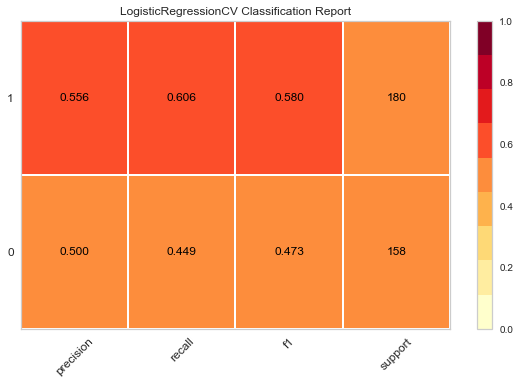

In [133]:
log_reg.classification_report(X_bow, y_train, X_bow_validation, y_validation)

In [134]:
log_reg.performance_metrics()

,Measure,Train,Test
0,ACCURACY,0.89,0.53
1,PRECISION,0.90,0.56
2,RECALL,0.89,0.53
3,F1 SCORE,0.89,0.53
4,AUC,0.89,0.53
5,AUC_Proba,0.96,0.54


### **Bow Vector:**

In [135]:
log_reg.fit_then_predict_vec(X_bow_vec, y_train, X_bow_validation_vec, y_validation, return_prob=True)
log_reg.performance_metrics()

0       1
1       1
2       1
3       1
4       1
       ..
1347    1
1348    1
1349    1
1350    1
1351    1
Length: 1352, dtype: int32


,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50


### **Tf-idf:**

In [136]:
log_reg.k_fold(X_tfidf, y_train, nsplits=3, nrepeats=20);
log_reg.fit_then_predict(X_tfidf, y_train, X_tfidf_validation, y_validation, return_prob=True)
log_reg.performance_metrics()

recall: mean: 0.745, std: 0.029
precision: mean: 0.742, std: 0.027
accuracy: mean: 0.725, std: 0.019
f1_weighted: mean: 0.725, std: 0.020
roc_auc: mean: 0.801, std: 0.022


,Measure,Train,Test
0,ACCURACY,0.90,0.52
1,PRECISION,0.90,0.55
2,RECALL,0.90,0.52
3,F1 SCORE,0.90,0.52
4,AUC,0.90,0.52
5,AUC_Proba,0.96,0.52


### **Tf-idf Vector:**

In [137]:
log_reg.fit_then_predict_vec(X_tfidf_vec, y_train, X_tfidf_validation_vec, y_validation, return_prob=True)
log_reg.performance_metrics()

0       1
1       1
2       1
3       1
4       1
       ..
1347    1
1348    1
1349    1
1350    1
1351    1
Length: 1352, dtype: int32


,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50


### **Hash**

In [138]:
log_reg.k_fold(X_hash, y_train, nsplits=3, nrepeats=20);
log_reg.fit_then_predict(X_hash, y_train, X_hash_validation, y_validation, return_prob=True)
log_reg.performance_metrics()

recall: mean: 0.807, std: 0.032
precision: mean: 0.780, std: 0.026
accuracy: mean: 0.775, std: 0.019
f1_weighted: mean: 0.775, std: 0.019
roc_auc: mean: 0.860, std: 0.016


,Measure,Train,Test
0,ACCURACY,0.91,0.54
1,PRECISION,0.91,0.56
2,RECALL,0.91,0.54
3,F1 SCORE,0.91,0.53
4,AUC,0.91,0.53
5,AUC_Proba,0.97,0.51


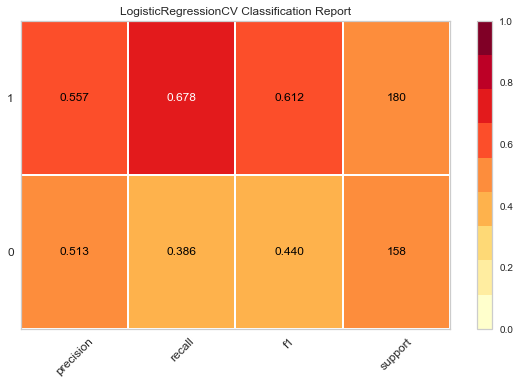

In [139]:
log_reg.classification_report(X_hash, y_train, X_hash_validation, y_validation)

### Words Embedding

In [141]:
# This takes too long to run
#log_reg.k_fold(X_vec, y_train, nsplits=3, nrepeats=20);

## **Gaussian Naive Bayes:**

___

In [142]:
nb = TextClassifier(GaussianNB())

### **Bow:**

In [143]:
# Insert comment here. 
nb.k_fold(X_bow, y_train, nsplits=3, nrepeats=20);
nb.fit_then_predict_vec(X_bow, y_train, X_bow_validation, y_validation)
nb.performance_metrics()

recall: mean: 0.710, std: 0.093
precision: mean: 0.782, std: 0.033
accuracy: mean: 0.738, std: 0.030
f1_weighted: mean: 0.736, std: 0.031
roc_auc: mean: 0.792, std: 0.019


IndexError: tuple index out of range

### **Bow Vector:**

In [ ]:
nb.fit_then_predict_vec(X_bow_vec, y_train, X_bow_validation_vec, y_validation)
nb.performance_metrics()

,Measure,Train,Test
0,ACCURACY,0.53,0.55
1,PRECISION,0.55,0.55
2,RECALL,0.53,0.55
3,F1 SCORE,0.50,0.51
4,AUC,0.52,0.53


### **Tf-idf:**

In [ ]:
# Insert comment here.
nb.k_fold(X_tfidf, y_train, nsplits=3, nrepeats=20);
nb.fit_then_predict(X_tfidf, y_train, X_tfidf_validation, y_validation, return_prob=True)
nb.performance_metrics()

recall: mean: 0.702, std: 0.089
precision: mean: 0.780, std: 0.033
accuracy: mean: 0.733, std: 0.028
f1_weighted: mean: 0.732, std: 0.030
roc_auc: mean: 0.786, std: 0.020


### **Tf-idf Vector:**

In [ ]:
nb.fit_then_predict_vec(X_tfidf_vec, y_train, X_tfidf_validation_vec, y_validation)
nb.performance_metrics()

,Measure,Train,Test
0,ACCURACY,0.50,0.51
1,PRECISION,0.54,0.54
2,RECALL,0.50,0.51
3,F1 SCORE,0.50,0.51
4,AUC,0.50,0.51


### **Hash:**

In [144]:
# Insert comment here.
nb.k_fold(X_hash, y_train, nsplits=3, nrepeats=20);
nb.fit_then_predict(X_hash, y_train, X_hash_validation, y_validation, return_prob=True)
nb.performance_metrics()

recall: mean: 0.950, std: 0.016
precision: mean: 0.687, std: 0.021
accuracy: mean: 0.742, std: 0.019
f1_weighted: mean: 0.726, std: 0.021
roc_auc: mean: 0.733, std: 0.019


,Measure,Train,Test
0,ACCURACY,0.78,0.51
1,PRECISION,0.72,0.53
2,RECALL,0.78,0.51
3,F1 SCORE,0.77,0.47
4,AUC,0.77,0.49
5,AUC_Proba,0.78,0.50


### **Words Embedding:**

In [145]:
# Insert comment here.
#nb.k_fold(X_vec, y_train, nsplits=3, nrepeats=20);
#nb.fit_then_predict(X_vec, y_train, X_vec_validation, y_validation, return_prob=True)
#nb.performance_metrics()

## **Random Forest Classifier:**

___

In [146]:
rf = TextClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_state))

### **bow:**

In [147]:
# Insert comment here. 
rf.k_fold(X_bow, y_train, nsplits=3, nrepeats=20);
rf.fit_then_predict(X_bow, y_train, X_bow_validation, y_validation, return_prob=True)
rf.performance_metrics()

recall: mean: 0.849, std: 0.043
precision: mean: 0.618, std: 0.036
accuracy: mean: 0.636, std: 0.029
f1_weighted: mean: 0.613, std: 0.038
roc_auc: mean: 0.711, std: 0.022


,Measure,Train,Test
0,ACCURACY,0.87,0.56
1,PRECISION,0.81,0.56
2,RECALL,0.87,0.56
3,F1 SCORE,0.87,0.52
4,AUC,0.86,0.54
5,AUC_Proba,0.98,0.52


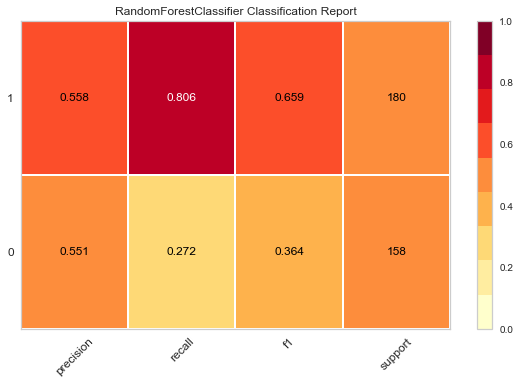

In [148]:
rf.classification_report(X_bow, y_train, X_bow_validation, y_validation)

### **Bow Vector:**

In [149]:
rf.fit_then_predict_vec(X_bow_vec, y_train, X_bow_validation_vec, y_validation, return_prob=True)
rf.performance_metrics()

0       1
1       1
2       1
3       1
4       1
       ..
1347    1
1348    1
1349    1
1350    1
1351    1
Length: 1352, dtype: int32


,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50


### **Tf-idf:**

In [150]:
# Insert comment here. 
rf.k_fold(X_tfidf, y_train, nsplits=3, nrepeats=20);
rf.fit_then_predict(X_tfidf, y_train, X_tfidf_validation, y_validation, return_prob=True)
rf.performance_metrics()

recall: mean: 0.825, std: 0.047
precision: mean: 0.614, std: 0.034
accuracy: mean: 0.627, std: 0.025
f1_weighted: mean: 0.607, std: 0.033
roc_auc: mean: 0.697, std: 0.023


,Measure,Train,Test
0,ACCURACY,0.88,0.51
1,PRECISION,0.83,0.53
2,RECALL,0.88,0.51
3,F1 SCORE,0.88,0.47
4,AUC,0.88,0.49
5,AUC_Proba,0.98,0.50


### **Hash:**

In [151]:
# Insert comment here. 
rf.k_fold(X_hash, y_train, nsplits=3, nrepeats=20);
rf.fit_then_predict(X_hash, y_train, X_hash_validation, y_validation, return_prob=True)
rf.performance_metrics()

recall: mean: 0.832, std: 0.048
precision: mean: 0.622, std: 0.036
accuracy: mean: 0.638, std: 0.026
f1_weighted: mean: 0.618, std: 0.035
roc_auc: mean: 0.708, std: 0.023


,Measure,Train,Test
0,ACCURACY,0.87,0.53
1,PRECISION,0.81,0.54
2,RECALL,0.87,0.53
3,F1 SCORE,0.87,0.49
4,AUC,0.86,0.51
5,AUC_Proba,0.96,0.51


### **Words Embedding:**

In [152]:
# Insert comment here.
#rf.k_fold(X_vec, y_train, nsplits=3, nrepeats=20);
#rf.fit_then_predict(X_vec, y_train, X_vec_validation, y_validation, return_prob=True)
#rf.performance_metrics()

## **Multi Layer Perceptron:**

In [153]:
mlp = TextClassifier(MLPClassifier(solver='adam', hidden_layer_sizes=(80,60,40), 
                         early_stopping=True,
                         activation='relu', random_state=random_state));

___

### **Bow:**

In [155]:
# Insert comment here. 
mlp.k_fold(X_bow, y_train, nsplits=3, nrepeats=20);
mlp.fit_then_predict(X_bow, y_train, X_bow_validation, y_validation)
mlp.performance_metrics()

recall: mean: 0.773, std: 0.041
precision: mean: 0.762, std: 0.031
accuracy: mean: 0.749, std: 0.023
f1_weighted: mean: 0.749, std: 0.023
roc_auc: mean: 0.832, std: 0.022


,Measure,Train,Test
0,ACCURACY,0.93,0.54
1,PRECISION,0.92,0.56
2,RECALL,0.93,0.54
3,F1 SCORE,0.93,0.53
4,AUC,0.93,0.53


### **Bow Vector:**

In [156]:
mlp.fit_then_predict_vec(X_bow_vec, y_train, X_bow_validation_vec, y_validation)
mlp.performance_metrics()

,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50


### **Tf-idf:**

In [157]:
# Insert comment here. 
mlp.k_fold(X_tfidf, y_train, nsplits=3, nrepeats=20);
mlp.fit_then_predict(X_tfidf, y_train, X_tfidf_validation, y_validation, return_prob=True)
mlp.performance_metrics()

recall: mean: 0.846, std: 0.073
precision: mean: 0.758, std: 0.068
accuracy: mean: 0.764, std: 0.062
f1_weighted: mean: 0.753, std: 0.097
roc_auc: mean: 0.855, std: 0.050


,Measure,Train,Test
0,ACCURACY,0.84,0.51
1,PRECISION,0.84,0.54
2,RECALL,0.84,0.51
3,F1 SCORE,0.84,0.51
4,AUC,0.84,0.51
5,AUC_Proba,0.92,0.52


### **Hash:**

In [158]:
# Insert comment here. 
mlp.k_fold(X_hash, y_train, nsplits=3, nrepeats=20);
mlp.fit_then_predict(X_hash, y_train, X_hash_validation, y_validation, return_prob=True)
mlp.performance_metrics()

recall: mean: 0.881, std: 0.097
precision: mean: 0.712, std: 0.138
accuracy: mean: 0.704, std: 0.129
f1_weighted: mean: 0.649, std: 0.204
roc_auc: mean: 0.811, std: 0.103


,Measure,Train,Test
0,ACCURACY,0.82,0.54
1,PRECISION,0.79,0.56
2,RECALL,0.82,0.54
3,F1 SCORE,0.82,0.53
4,AUC,0.81,0.53
5,AUC_Proba,0.90,0.51


### **Words Embedding:**

In [159]:
# Insert comment here.
#mlp.k_fold(X_vec, y_train, nsplits=3, nrepeats=20);
#mlp.fit_then_predict(X_vec, y_train, X_vec_validation, y_validation, return_prob=True)
#mlp.performance_metrics()

## **Adaboost:**

___

In [160]:
ada = TextClassifier(AdaBoostClassifier(base_estimator=LogisticRegression(random_state=random_state),
                               n_estimators=200, random_state=random_state));


### **Bow**

In [161]:
# Insert comment here.
ada.k_fold(X_bow, y_train, nsplits=3, nrepeats=20);
ada.fit_then_predict(X_bow, y_train, X_bow_validation, y_validation, return_prob=True)
ada.performance_metrics()

recall: mean: 0.777, std: 0.029
precision: mean: 0.761, std: 0.025
accuracy: mean: 0.750, std: 0.018
f1_weighted: mean: 0.750, std: 0.018
roc_auc: mean: 0.838, std: 0.016


,Measure,Train,Test
0,ACCURACY,0.84,0.51
1,PRECISION,0.85,0.54
2,RECALL,0.84,0.51
3,F1 SCORE,0.84,0.51
4,AUC,0.84,0.51
5,AUC_Proba,0.93,0.54


### **Bow Vector**

In [162]:
ada.fit_then_predict_vec(X_bow_vec, y_train, X_bow_validation_vec, y_validation)
ada.performance_metrics()

,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50


### **Tfidf**

In [163]:
# Insert comment here.
ada.k_fold(X_tfidf, y_train, nsplits=3, nrepeats=20);
ada.fit_then_predict(X_tfidf, y_train, X_tfidf_validation, y_validation, return_prob=True)
ada.performance_metrics()

recall: mean: 1.000, std: 0.000
precision: mean: 0.534, std: 0.019
accuracy: mean: 0.535, std: 0.020
f1_weighted: mean: 0.374, std: 0.025
roc_auc: mean: 0.833, std: 0.017


,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50
5,AUC_Proba,0.89,0.50


### **Hash**

In [164]:
# Insert comment here.
ada.k_fold(X_hash, y_train, nsplits=3, nrepeats=20);
ada.fit_then_predict(X_hash, y_train, X_hash_validation, y_validation, return_prob=True)
ada.performance_metrics()

recall: mean: 1.000, std: 0.000
precision: mean: 0.534, std: 0.018
accuracy: mean: 0.534, std: 0.018
f1_weighted: mean: 0.372, std: 0.021
roc_auc: mean: 0.749, std: 0.020


,Measure,Train,Test
0,ACCURACY,0.53,0.53
1,PRECISION,0.53,0.53
2,RECALL,0.53,0.53
3,F1 SCORE,0.37,0.37
4,AUC,0.50,0.50
5,AUC_Proba,0.79,0.50


### **Words Embedding:**

In [165]:
# Insert comment here.
#ada.k_fold(X_vec, y_train, nsplits=3, nrepeats=20);
#ada.fit_then_predict(X_vec, y_train, X_vec_validation, y_validation, return_prob=True)
#ada.performance_metrics()

##  **LSTM:**

___

(13, 25)
(1352, 1747, 25)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1747, 25)]        0         
                                                                 
 masking (Masking)           (None, 1747, 25)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 4)                448       
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 10        
                                                                 
Total params: 458
Trainable params: 458
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
34/34 [==============================] - 851s 25s/step - loss: 0.7000 - binary_accuracy: 0.54

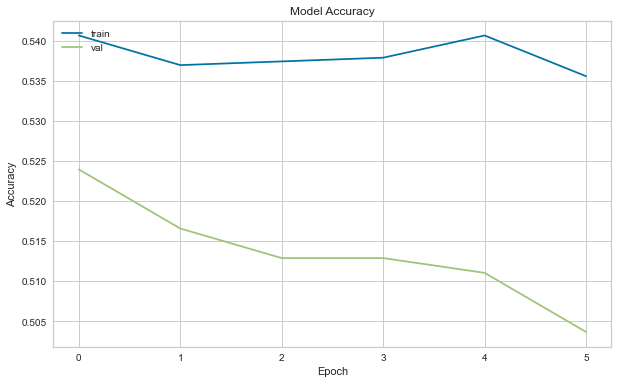

In [123]:
tf.random.set_seed(random_state)
if train_w2v or load_w2v:
    tf.config.run_functions_eagerly(True)
    tf.data.experimental.enable_debug_mode()
    print(np.array(X_vec_per_headline[0][0]).shape)
    pad_to = len(max(X_train['HeadlinesTotal']))
    X_vec_headlines_total = []
    for row in range(0, len(X_vec_per_headline[0])):
        row_vec = np.zeros((pad_to, 25))
        for headline in range(0, len(Headlines)):
            for word in range(0, len(X_vec_per_headline[headline][row])):
                row_vec[headline*len(Headlines)+word] = X_vec_per_headline[headline][row][word]
            #row_vec = np.append(row_vec, X_vec_per_headline[headline][row])
        X_vec_headlines_total.append(row_vec)
    
    X_tensor = tf.convert_to_tensor(X_vec_headlines_total, dtype='float32')
    print(X_tensor.shape)

    '''
    model input in the shape(number of words per doc, word embedding size)
    number of words(time steps) and the size of embeddings
    '''
    input_ = Input(shape=(pad_to, 25))

    '''
    mask layer to avoid model from considering padding vectors
    ingore the zero vectors
    '''
    mask_layer = Masking(mask_value=0)
    mask = mask_layer(input_)

    '''
    BiLSTM layer
    Forward and backward neural network
    '''

    lstm = Bidirectional(LSTM(units=2))(mask)

    '''activation layer'''
    act = Dense(2, activation='sigmoid')(lstm)

    '''model input and output'''
    model = Model(input_, act)

    '''model loss function and evaluation metrics'''
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
    model.summary()

    #lstm = TextClassifier(model)
    y_tf_train = tf.one_hot(y_train, depth=2)
    history = model.fit(X_tensor, y_tf_train, batch_size=32, epochs=6, verbose=1, validation_split=0.20, workers=4)

    import matplotlib.pyplot as plt
    plt.figure(figsize =(10, 6))
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# <center> **THE END.**